# Using Current Data To Make Recommendations
### Model #1: (Classification - Fully Paid vs. Default) 
### Model #2: ( Regression - Annualized Return %)

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_new_LC_data_classification_current,clean_LC_data_classification_eval,
                                   preprocessing_current, preprocessing_future_test, columns_list, 
                                   nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_current, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification, 
                                   view_columns_by_number_of_rows_that_have_nan,
                                   current_pipeline, str_to_float_cols)
from functions_and_objects import (prep_df_for_regression_current,
                                   calc_annu_return,impute_annu_return_to_y,
                                   scale_current)

import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression
from sklearn.preprocessing import StandardScaler
%load_ext autoreload
%autoreload 2

### Import New Data from 7.29.19

In [2]:
browseNotes = pd.read_csv('~/Downloads/primaryMarketNotes_browseNotes_1-RETAIL (2).csv')
browseNotes.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,157578044,196023243,10000.0,9975.0,36,16.95,7.96,1.23,356.28,C,...,,,,,,,,,,
1,156789911,194619088,14000.0,10875.0,36,25.65,12.86,1.52,561.47,D,...,,,,,,,,,,
2,156951202,195031092,30000.0,15000.0,36,18.62,12.86,1.52,1093.93,D,...,,,,,,,,,,
3,157288919,195526240,15300.0,14550.0,60,17.74,7.49,0.87,386.36,C,...,06-18-2004 17:00:00,0,2,6,79.2,3,16,0,0,20
4,157199170,195391208,35000.0,25900.0,36,14.30,7.96,1.23,1201.33,C,...,,,,,,,,,,


In [3]:
dfs_list = [browseNotes]

In [4]:
browseNotes.shape

(83, 122)

In [5]:
browseNotes['all_util'][80]

47.4

In [6]:
browseNotes['revol_util'][17]

34.2

### Load DF from Pipeline

In [7]:
(X_current_regr, y_current, table_all_current) = current_pipeline(dfs_list, '../nn_v8.joblib', '../rf_regr_v5.joblib')

/Users/flatironschool/Desktop/flatiron/blogs_and_projects/peervest/notebooks_functions/functions_and_objects.py:417: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days


[]


Using TensorFlow backend.
W0829 13:20:01.654213 4448560576 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 13:20:01.698459 4448560576 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 13:20:01.836836 4448560576 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 13:20:01.837617 4448560576 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0829 13:20:01.838304 4448560576 depr

In [8]:
len(y_current[(y_current['prob_default'] < 1) & (y_current['return_preds'] > -.1)])

64

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


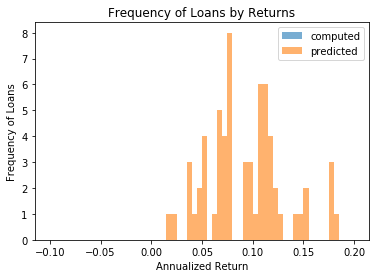

In [9]:
plt.hist(table_all_current['annu_return'],bins=60,range=(-0.1,0.2),label='computed',alpha=0.6)
plt.hist(table_all_current['return_preds'],bins=60,range=(-0.1,0.2),label='predicted',alpha=0.6)
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.legend()
plt.title('Frequency of Loans by Returns')
plt.show()

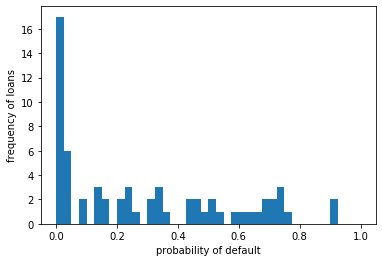

In [10]:
plt.hist(table_all_current['prob_default'],bins=40, range=(0,1))
plt.xlabel('probability of default')
plt.ylabel('frequency of loans')
plt.show()

In [11]:
table_all_current.drop(columns=['annu_return'],inplace=True)

In [12]:
table_all_current

,prob_default,prob_fullypaid,return_preds,loan_amnt,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,...,emp_title_2_Technician,emp_title_2_Truck Driver,emp_title_2_Vice President,emp_title_2_driver,emp_title_2_manager,emp_title_2_owner,emp_title_2_sales,emp_title_2_supervisor,emp_title_2_teacher,emp_title_2_truck driver
id,,,,,,,,,,,,,,,,,,,,,
156789911,0.919934,0.080066,0.183188,14000,10875.0,0.2565,1.0,65000.0,34.05,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156951202,0.006789,0.993211,0.124198,30000,15000.0,0.1862,4.0,47000.0,28.40,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157288919,0.463996,0.536004,0.107771,15300,14550.0,0.1774,1.0,47000.0,26.30,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157199170,0.211109,0.788891,0.094950,35000,25900.0,0.1430,2.0,100000.0,7.26,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157166141,0.125657,0.874343,0.053553,31575,18975.0,0.0881,1.0,42000.0,51.83,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157419727,0.028728,0.971272,0.066534,20000,15400.0,0.1033,0.0,65000.0,24.32,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156746122,0.013898,0.986102,0.122606,37225,8325.0,0.1862,3.0,76000.0,34.34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156275009,0.160577,0.839423,0.106147,30000,23225.0,0.1524,0.0,50000.0,16.75,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156264141,0.077973,0.922027,0.125742,30000,23950.0,0.1797,1.0,250000.0,15.42,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
table_all_current.to_pickle('table_all_current_8.29.19.pkl')